In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from utils import SyntheticData, plot_decision_boundary, get_accuracy
from torch.utils.data import DataLoader
%matplotlib inline

class CompositeNetwork(nn.Module):
    def __init__(self, input_dimension, output_dimension, num_hidden_layers=10, neurons_per_layer=100):
        super(CompositeNetwork, self).__init__()
        
        def get_layer_with_elu(in_features, out_features, bias=True):
            return nn.Linear(in_features, out_features, bias=bias), nn.ELU()
        
        self.middle_dense = itertools.chain.from_iterable(get_layer_with_elu(in_features=neurons_per_layer, 
                                                                             out_features=neurons_per_layer) for i in range(num_hidden_layers-2))
    
        
        self.model = nn.Sequential(
            nn.Linear(in_features=input_dimension,
                      out_features=neurons_per_layer,
                      bias=True),
            nn.ELU(),
            *self.middle_dense, 
            nn.Linear(in_features=neurons_per_layer,
                      out_features=output_dimension,
                      bias=True)
            )
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def predict(self, x):
        pass
            
def weight_initializer(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
net = CompositeNetwork(input_dimension=2, output_dimension=1, num_hidden_layers=10, neurons_per_layer=100)
net.apply(weight_initializer)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_data = SyntheticData(400, seed=1)
test_data = SyntheticData(10000, seed=10)

In [ ]:
current_epoch = 0
while True:
    optimizer.zero_grad()
    outputs = net(train_data.data)
    sigmoid = nn.Sigmoid()
    loss = criterion(sigmoid(outputs), train_data.target)
    loss.backward()
    optimizer.step()

    accuracy = get_accuracy(outputs, train_data.target)
    
    if current_epoch % 100 == 0:
        outputs_test = net(test_data.data)
        accuracy_test = get_accuracy(outputs_test, test_data.target)
        print("Accuracy (train): %.3f. Accuracy (validation): %.3f. Loss: %.3f." % (accuracy, accuracy_test, loss.item()))
            
    current_epoch += 1
    if accuracy == 1:
        print("Goal reached after %d epochs" % current_epoch)
        break

Accuracy (train): 0.565. Accuracy (validation): 0.630. Loss: 0.970.
Accuracy (train): 0.880. Accuracy (validation): 0.855. Loss: 0.282.


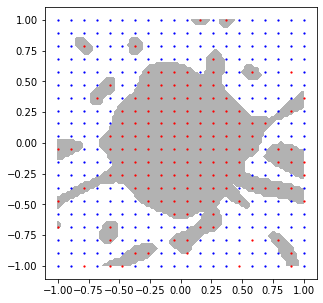

In [12]:
plot_decision_boundary(100, net, train_data)